In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline

In [ ]:
!pip install datasets transformers

In [6]:

cmv_df = pd.read_csv('/content/Cleaned_UW_RMP.csv')
# Max emotions represents the total emotions generated for each comment (ie our max)
# Min emotions represents the minimum number of emotions we accept for each comment (threshold)
max_emotions = 6
min_emotions = 3
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=max_emotions)

test_comment_1 = cmv_df.iloc[0]['Review-Body']


sentences = [test_comment_1]

print("Initial 3 labels")
for sentence in sentences:
  output = classifier(sentence)
  print(output)

print("")
print("Filtered 3 labels")

# Builds a list of labels to filter out
labels_to_exclude = ['neutral', 'approval']

for sentence in sentences:
    output = classifier(sentence)
    filtered_labels = []
    num_labels = 0

    # Check predictions and filter out labels that are found in the labels_to_exclude
    for prediction in output:
        filtered_predictions = [label for label in prediction if label['label'] not in labels_to_exclude]
        # Check to see if we still need to add more emotions to reach the minimum threshold for classification
        if (num_labels < min_emotions):
          # If we have not reached the min threshold, keep adding emotions
          filtered_labels.append(filtered_predictions)
          num_labels += 1

    print(filtered_labels)




Initial 3 labels
[[{'label': 'neutral', 'score': 0.3654744029045105}, {'label': 'disapproval', 'score': 0.31943556666374207}, {'label': 'disappointment', 'score': 0.23140540719032288}, {'label': 'annoyance', 'score': 0.21146126091480255}, {'label': 'embarrassment', 'score': 0.06383753567934036}, {'label': 'realization', 'score': 0.031293466687202454}]]

Filtered 3 labels
[[{'label': 'disapproval', 'score': 0.31943556666374207}, {'label': 'disappointment', 'score': 0.23140540719032288}, {'label': 'annoyance', 'score': 0.21146126091480255}, {'label': 'embarrassment', 'score': 0.06383753567934036}, {'label': 'realization', 'score': 0.031293466687202454}]]


In [13]:

import pandas as pd
from transformers import pipeline
from datasets import Dataset
from concurrent.futures import ThreadPoolExecutor, as_completed

# Load dataset into a Pandas DataFrame
cmv_df = pd.read_csv('/content/Cleaned_UW_RMP.csv')

# Initialize the text classification pipeline with GPU support
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5, device=0)

# Initialize a dictionary to store emotion frequencies
emotion_frequency = {}

# Function to process a batch of texts
def process_batch(batch_comments):
    outputs = classifier(batch_comments)
    local_emotion_frequency = {}
    for output in outputs:
        emotion_labels = [label['label'] for label in output]
        for emotion_label in emotion_labels:
            if emotion_label not in local_emotion_frequency:
                local_emotion_frequency[emotion_label] = 1
            else:
                local_emotion_frequency[emotion_label] += 1
    return local_emotion_frequency

# Batch processing with parallel execution
batch_size = 32  # Adjust the batch size according to your memory capacity
comments = cmv_df['Review-Body'].dropna().tolist()
batches = [comments[i:i + batch_size] for i in range(0, len(comments), batch_size)]

with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust number of workers based on your environment
    futures = {executor.submit(process_batch, batch): batch for batch in batches}
    for future in as_completed(futures):
        batch_emotion_frequency = future.result()
        for emotion, count in batch_emotion_frequency.items():
            if emotion not in emotion_frequency:
                emotion_frequency[emotion] = count
            else:
                emotion_frequency[emotion] += count

# Print the final resulting emotion frequencies
print("Final Emotion Frequencies:")
for emotion, count in emotion_frequency.items():
    print(f"{emotion}: {count}")






Final Emotion Frequencies:
neutral: 8341
disapproval: 4000
disappointment: 2650
annoyance: 3704
embarrassment: 33
admiration: 6837
approval: 8002
caring: 1382
joy: 2221
optimism: 2621
gratitude: 989
realization: 2622
love: 1011
amusement: 1419
excitement: 817
confusion: 623
desire: 259
curiosity: 246
anger: 883
relief: 117
pride: 72
disgust: 541
nervousness: 25
fear: 161
sadness: 281
remorse: 42
surprise: 99
grief: 7


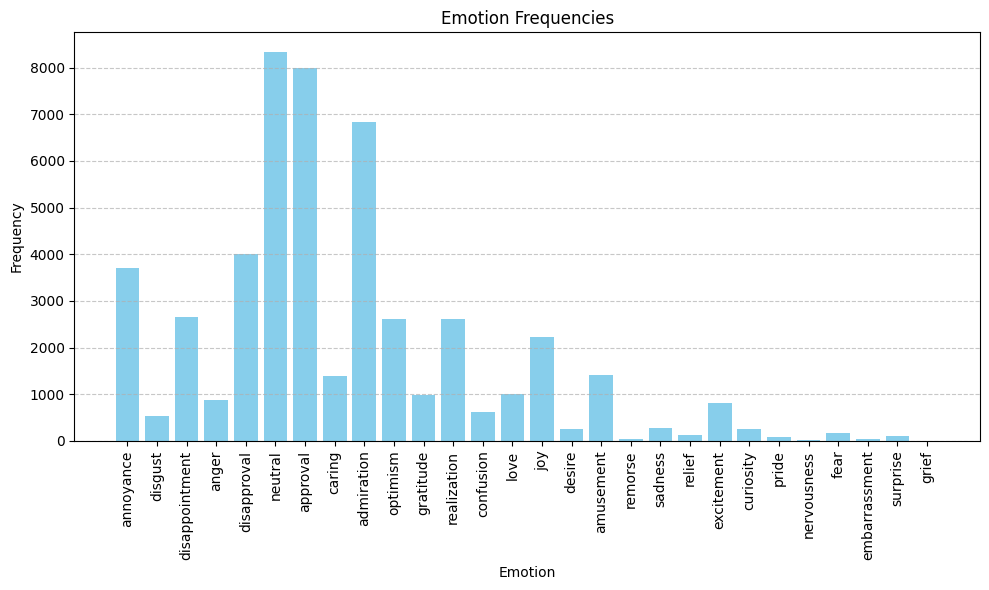

In [7]:
import matplotlib.pyplot as plt

# Extract emotion labels and corresponding frequencies from our final list
emotions = list(emotion_frequency.keys())
frequencies = list(emotion_frequency.values())

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, frequencies, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Frequencies')
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout to prevent label clips
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load dataset into a Pandas DataFrame
cmv_df = pd.read_csv('/content/Cleaned_UW_RMP.csv')

# Initialize the text classification pipeline with GPU support
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5, device=0)

# Function to process a batch of texts
def process_batch(batch_comments):
    outputs = classifier(batch_comments)
    emotion_scores = []
    for output in outputs:
        score_dict = {label['label']: label['score'] for label in output}
        emotion_scores.append(score_dict)
    return emotion_scores

# Batch processing with parallel execution
batch_size = 32  # Adjust the batch size according to your memory capacity
comments = cmv_df['Review-Body'].dropna().tolist()
batches = [comments[i:i + batch_size] for i in range(0, len(comments), batch_size)]

all_emotion_scores = []
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust number of workers based on your environment
    futures = {executor.submit(process_batch, batch): batch for batch in batches}
    for future in as_completed(futures):
        batch_emotion_scores = future.result()
        all_emotion_scores.extend(batch_emotion_scores)

# Create a DataFrame with emotion scores
emotion_scores_df = pd.DataFrame(all_emotion_scores)

# Add difficulty ratings to the DataFrame
cmv_df = cmv_df.dropna(subset=['Review-Body']).reset_index(drop=True)
emotion_scores_df['Difficulty'] = cmv_df['Difficulty']

# Extract annoyance scores
emotion_scores_df['annoyance'] = emotion_scores_df['annoyance'].fillna(0)

# Perform statistical analysis
model = ols('annoyance ~ C(Difficulty)', data=emotion_scores_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA Table:")
print(anova_table)

print("\nRegression Summary:")
print(model.summary())

# Aggregate annoyance scores by difficulty rating
annoyance_by_difficulty = emotion_scores_df.groupby('Difficulty')['annoyance'].mean().reset_index()

print("\nAverage Annoyance Score by Difficulty Rating:")
print(annoyance_by_difficulty)



ANOVA Table:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    8.405729     4.0  95.058601  1.698114e-79
Residual       220.978614  9996.0        NaN           NaN

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              annoyance   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     95.06
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           1.70e-79
Time:                        21:24:14   Log-Likelihood:                 4873.0
No. Observations:               10001   AIC:                            -9736.
Df Residuals:                    9996   BIC:                            -9700.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         

In [3]:
import pandas as pd
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load your dataset into a Pandas DataFrame
cmv_df = pd.read_csv('/content/Cleaned_UW_RMP.csv')

# Initialize the text classification pipeline with GPU support
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5, device=0)

# Function to process a batch of texts
def process_batch(batch_comments):
    outputs = classifier(batch_comments)
    emotion_scores = []
    for output in outputs:
        score_dict = {label['label']: label['score'] for label in output}
        emotion_scores.append(score_dict)
    return emotion_scores

# Batch processing with parallel execution
batch_size = 32  # Adjust the batch size according to your memory capacity
comments = cmv_df['Review-Body'].dropna().tolist()
batches = [comments[i:i + batch_size] for i in range(0, len(comments), batch_size)]

all_emotion_scores = []
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust number of workers based on your environment
    futures = {executor.submit(process_batch, batch): batch for batch in batches}
    for future in as_completed(futures):
        batch_emotion_scores = future.result()
        all_emotion_scores.extend(batch_emotion_scores)

# Create a DataFrame with emotion scores
emotion_scores_df = pd.DataFrame(all_emotion_scores)

# Add quality ratings to the DataFrame
cmv_df = cmv_df.dropna(subset=['Review-Body']).reset_index(drop=True)
emotion_scores_df['Quality'] = cmv_df['Quality']

# Extract annoyance scores
emotion_scores_df['annoyance'] = emotion_scores_df['annoyance'].fillna(0)

# Perform statistical analysis
model = ols('annoyance ~ C(Quality)', data=emotion_scores_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA Table:")
print(anova_table)

print("\nRegression Summary:")
print(model.summary())

# Aggregate annoyance scores by quality rating
annoyance_by_quality = emotion_scores_df.groupby('Quality')['annoyance'].mean().reset_index()

print("\nAverage Annoyance Score by Quality Rating:")
print(annoyance_by_quality)


ANOVA Table:
                sum_sq      df           F  PR(>F)
C(Quality)   49.325269     8.0  342.150266     0.0
Residual    180.059075  9992.0         NaN     NaN

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              annoyance   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     342.2
Date:                Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:30:02   Log-Likelihood:                 5897.0
No. Observations:               10001   AIC:                        -1.178e+04
Df Residuals:                    9992   BIC:                        -1.171e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       

In [4]:
import pandas as pd
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load your dataset into a Pandas DataFrame
cmv_df = pd.read_csv('/content/Cleaned_UW_RMP.csv')

# Initialize the text classification pipeline with GPU support
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5, device=0)

# Function to process a batch of texts
def process_batch(batch_comments):
    outputs = classifier(batch_comments)
    emotion_scores = []
    for output in outputs:
        score_dict = {label['label']: label['score'] for label in output}
        emotion_scores.append(score_dict)
    return emotion_scores

# Batch processing with parallel execution
batch_size = 32  # Adjust the batch size according to your memory capacity
comments = cmv_df['Review-Body'].dropna().tolist()
batches = [comments[i:i + batch_size] for i in range(0, len(comments), batch_size)]

all_emotion_scores = []
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust number of workers based on your environment
    futures = {executor.submit(process_batch, batch): batch for batch in batches}
    for future in as_completed(futures):
        batch_emotion_scores = future.result()
        all_emotion_scores.extend(batch_emotion_scores)

# Create a DataFrame with emotion scores
emotion_scores_df = pd.DataFrame(all_emotion_scores)

# Add quality ratings to the DataFrame
cmv_df = cmv_df.dropna(subset=['Review-Body']).reset_index(drop=True)
emotion_scores_df['Quality'] = cmv_df['Quality']

# Extract approval scores
emotion_scores_df['approval'] = emotion_scores_df['approval'].fillna(0)

# Perform statistical analysis
model = ols('approval ~ C(Quality)', data=emotion_scores_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA Table:")
print(anova_table)

print("\nRegression Summary:")
print(model.summary())

# Aggregate approval scores by quality rating
approval_by_quality = emotion_scores_df.groupby('Quality')['approval'].mean().reset_index()

print("\nAverage Approval Score by Quality Rating:")
print(approval_by_quality)


ANOVA Table:
                sum_sq      df           F         PR(>F)
C(Quality)   14.779966     8.0  106.432949  3.718402e-171
Residual    173.444198  9992.0         NaN            NaN

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:               approval   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     106.4
Date:                Sun, 02 Jun 2024   Prob (F-statistic):          3.72e-171
Time:                        21:56:01   Log-Likelihood:                 6084.1
No. Observations:               10001   AIC:                        -1.215e+04
Df Residuals:                    9992   BIC:                        -1.209e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
  

In [5]:
import pandas as pd
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load your dataset into a Pandas DataFrame
cmv_df = pd.read_csv('/content/Cleaned_UW_RMP.csv')

# Initialize the text classification pipeline with GPU support
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5, device=0)

# Function to process a batch of texts
def process_batch(batch_comments):
    outputs = classifier(batch_comments)
    emotion_scores = []
    for output in outputs:
        score_dict = {label['label']: label['score'] for label in output}
        emotion_scores.append(score_dict)
    return emotion_scores

# Batch processing with parallel execution
batch_size = 32  # Adjust the batch size according to your memory capacity
comments = cmv_df['Review-Body'].dropna().tolist()
batches = [comments[i:i + batch_size] for i in range(0, len(comments), batch_size)]

all_emotion_scores = []
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust number of workers based on your environment
    futures = {executor.submit(process_batch, batch): batch for batch in batches}
    for future in as_completed(futures):
        batch_emotion_scores = future.result()
        all_emotion_scores.extend(batch_emotion_scores)

# Create a DataFrame with emotion scores
emotion_scores_df = pd.DataFrame(all_emotion_scores)

# Add difficulty ratings to the DataFrame
cmv_df = cmv_df.dropna(subset=['Review-Body']).reset_index(drop=True)
emotion_scores_df['Difficulty'] = cmv_df['Difficulty']

# Extract approval scores
emotion_scores_df['approval'] = emotion_scores_df['approval'].fillna(0)

# Perform statistical analysis
model = ols('approval ~ C(Difficulty)', data=emotion_scores_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA Table:")
print(anova_table)

print("\nRegression Summary:")
print(model.summary())

# Aggregate approval scores by difficulty rating
approval_by_difficulty = emotion_scores_df.groupby('Difficulty')['approval'].mean().reset_index()

print("\nAverage Approval Score by Difficulty Rating:")
print(approval_by_difficulty)


ANOVA Table:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    3.707251     4.0  50.209062  6.589510e-42
Residual       184.516913  9996.0        NaN           NaN

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:               approval   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     50.21
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           6.59e-42
Time:                        21:59:47   Log-Likelihood:                 5774.7
No. Observations:               10001   AIC:                        -1.154e+04
Df Residuals:                    9996   BIC:                        -1.150e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         